In [3]:
#!/usr/bin/env python
# coding: utf-8

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from LogGabor import LogGabor
from what_where.main import init, MNIST
from what_where.where import RetinaFill, WhereShift, RetinaBackground, RetinaMask
from POLO.PYramid2 import cropped_pyramid, local_filter, get_K, log_gabor_transform
from POLO.PYramid2 import inverse_pyramid, get_K_inv, inverse_gabor
from utils import view_data
from typing import List, Tuple

import pickle

width = {'in': 32, 'out': 64, 'ext': 128}

n_levels = {'in': 3, 'out': 3, 'ext': 3} 

base_levels = 2

n_color = {'in': 3, 'out': 3, 'ext': 3}

color = True

color_mode= 'rgb' #'lab' # 'hsv' #True

r_min = {'in': width['in'] / 4, 'out': width['out'] / 4, 'ext': width['ext'] / 4}

r_max = {'in': width['in'] / 2, 'out': width['out'] / 2, 'ext': width['ext'] / 2}

n_sublevel = n_eccentricity = {'in': 2, 'out': 4, 'ext': 8}

n_azimuth = {'in': 16, 'out': 32, 'ext': 64}

n_theta = {'in': 8, 'out': 8, 'ext': 8}

n_phase = {'in': 1, 'out': 1, 'ext': 1}

do_mask = False

gauss = False



lg={}
for k in ['in', 'out', 'ext']:
    pe = {'N_X': width[k], 'N_Y': width[k], 'do_mask': do_mask, 'base_levels':
              base_levels, 'n_theta': 0, 'B_sf': np.inf, 'B_theta': np.inf ,
          'use_cache': True, 'figpath': 'results', 'edgefigpath':
              'results/edges', 'matpath': 'cache_dir', 'edgematpath':
              'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
              14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}   

    lg[k] = LogGabor(pe)



K = {}
for k in ['in', 'out', 'ext']:
    K[k] = get_K(width=width[k],
          n_sublevel = n_sublevel[k], 
          n_azimuth = n_azimuth[k], 
          n_theta = n_theta[k],
          n_phase = n_phase[k], 
          r_min = r_min[k], 
          r_max = r_max[k], 
          log_density_ratio = 2, 
          verbose=True,
          lg=lg[k])




args = init(filename='2020-07-01')
args


# In[7]:


class DualCroppedPyramid(object):
    def __init__(self, width, 
                 base_levels, 
                 color=color, 
                 do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb'):
        self.width = width
        self.base_levels = base_levels
        self.color = color
        self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode

    def __call__(self, img):
        img_crop = {}
        for k in ['in', 'out', 'ext']:
            img_crop_part, level_size = cropped_pyramid(img.unsqueeze(0), 
                                               width=self.width[k], 
                                               base_levels=self.base_levels,
                                               color=self.color, 
                                               do_mask=self.do_mask, 
                                               verbose=self.verbose,
                                               squeeze=True,
                                               gauss=gauss,
                                               n_levels=self.n_levels[k],
                                               color_mode=self.color_mode)
            #print(img_crop_part.shape)
            img_crop[k] = img_crop_part[:self.n_levels[k]-1,...]
        return img, img_crop   




class DualLogGaborTransform(object):
    def __init__(self, K=K, color=color, verbose=False):
        self.K = K
        self.color = color
        self.verbose = verbose

    def __call__(self, cropped_pyr):
        img = cropped_pyr[0]
        img_crop = cropped_pyr[1]
        log_gabor_coeffs = {}
        for k in ['in', 'out', 'ext']:
            log_gabor_coeffs[k] = log_gabor_transform(img_crop[k].unsqueeze(1), K[k], color=self.color).squeeze(1)
        
        return img, log_gabor_coeffs




class DualLogGaborReshape(object):
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color, verbose=False):
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase  
        self.color = color
        self.verbose = verbose

    def __call__(self, log_gabor_transform):
        img = log_gabor_transform[0]
        log_gabor_coeffs = log_gabor_transform[1]
        for k in ['in', 'out', 'ext']:
            # n_batch, n_levels, n_color, n_sublevel, n_azimuth, n_theta, n_phase
            # x      , 0       , 1      , 2         , 3        , 4      , 5
            # 
            #print(log_gabor_coeffs[k].shape)
            log_gabor_coeffs[k] = log_gabor_coeffs[k].permute(1, 4, 5, 0, 2, 3).contiguous()
            log_gabor_coeffs[k] = log_gabor_coeffs[k].view(self.n_color[k]*self.n_theta[k]*self.n_phase[k], 
                                                     (self.n_levels[k]-1) * self.n_eccentricity[k], 
                                                     self.n_azimuth[k])
 
        return img, log_gabor_coeffs



v_mean = np.array([0.485, 0.456, 0.406])
v_std = np.array([0.229, 0.224, 0.225])
transforms_norm = transforms.Normalize(mean=v_mean, std=v_std) # to normalize colors on the imagenet dataset

image_size = 256

polo_transform =  transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            #transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            transforms_norm, 
            DualCroppedPyramid(width=width, 
                  base_levels=base_levels,
                  color=color,
                  n_levels=n_levels),
            DualLogGaborTransform(K=K, color=color),
            DualLogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color),
        ])

# In[17]:


#image_path = "/envau/work/brainets/dauce.e/data/animal/"
#image_path = "/media/manu/Seagate Expansion Drive/Data/animal/"
image_path = "/home/INT/dauce.e/data/Imagenet_full/"
#image_path = "/run/user/1001/gvfs/sftp:host=bag-008-de03/envau/work/brainets/dauce.e/data/animal/"
#image_path = "../data/animal/"

image_dataset = { 'train' : datasets.ImageFolder(
                            image_path+'train', 
                            transform=polo_transform
                        ),
                  'test' : datasets.ImageFolder(
                            image_path+'val', 
                            transform=polo_transform
                        )
                }

# In[18]:


dataset_size = {'train' : len(image_dataset['train']),
                'test' : len(image_dataset['test'])}

dataset_size['train'], dataset_size['test']


# In[19]:


args.batch_size = 50
num_workers = 1

dataloader = { 'train' : torch.utils.data.DataLoader(
                            image_dataset['train'], batch_size=args.batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        ),
               'test' : torch.utils.data.DataLoader(
                            image_dataset['test'], batch_size=args.batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        )
             }



# # Creating an Attention Transformer model with log-polar entry (POLO-STN)

# In[28]:


transform_in =  transforms.Compose([
            DualCroppedPyramid(width=width, 
                  base_levels=base_levels,
                  color=color,
                  n_levels=n_levels),
            DualLogGaborTransform(K=K, color=color),
            DualLogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color),
        ])


# In[29]:


def negentropy_loss(model, z):
    z_mean = torch.mean(z, dim=0) + 1e-6
    z_std = torch.std(z, dim=0)
    if model.do_stn or args.radius > 0:
        p = torch.distributions.Normal(torch.ones_like(z)*z_mean, torch.ones_like(z) * z_std)
    else:
        p = torch.distributions.Normal(torch.zeros_like(z), 1e-6 * torch.ones_like(z))

    #p = torch.distributions.Normal(torch.ones_like(z)*z_mean, torch.ones_like(z) * z_std)
    return p.log_prob(z).sum()

def kl_divergence(model, z):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------
    # 1. define the first two probabilities (in this case Normal for both)
    z_dims = z.size()
    if args.radius > 0:
        #p = torch.distributions.Normal(torch.zeros_like(z), args.radius * torch.ones_like(z))
        p = torch.distributions.MultivariateNormal(torch.zeros_like(z), 
                                                   args.radius * torch.einsum('i,jk->ijk',torch.ones(z_dims[0]), torch.eye(2)))
    else:
        p = torch.distributions.Normal(torch.zeros_like(z), 1e-6 * torch.ones_like(z))


    # 2. get the probabilities from the equation
    #log_qzx = model.q.log_prob(z)
    log_pz = p.log_prob(z)

    z_mean = torch.mean(z, dim=0)
    z_std = torch.std(z, dim=0) + 1e-6
    #print(z)
    #print(torch.cov(z.T))
    #print(torch.eye(2))
    z_cov = torch.cov(z.T) + 1e-6 * torch.eye(2).to(device)
    #print(z_std)
    #q = torch.distributions.MultivariateNormal(torch.ones_like(z)*z_mean, torch.ones_like(z) * z_std)
    q = torch.distributions.MultivariateNormal(torch.ones_like(z)*z_mean, torch.ones(z_dims[0], 2, 2).to(device) * z_cov)
    log_qzx = q.log_prob(z)

    # kl
    kl = (log_qzx - log_pz)
    
    # sum over last dim to go from single dim distribution to multi-dim
    kl = kl.sum()
    return kl

# In[30]:
class Polo_AttentionTransNet(nn.Module):
    
    def __init__(self, do_stn=True, do_what=False, deterministic=False, LAMBDA=.1):
        super(Polo_AttentionTransNet, self).__init__()
        
        self.do_stn = do_stn
        self.do_what = do_what
        self.deterministic = deterministic
        
        self.LAMBDA = LAMBDA

        ##  The what pathway
        self.wloc0 = nn.Conv2d(n_color['ext'] * n_theta['ext'] * n_phase['ext'], 
                              50, 3, padding=1)
        self.wloc1a = nn.Conv2d(50, 100, 3, padding=1)
        self.wloc1b = nn.Conv2d(n_color['out'] * n_theta['out'] * n_phase['out'], 
                              100, 3, padding=1)
        self.wloc2a = nn.Conv2d(100, 200, 3, padding=1)
        self.wloc2b = nn.Conv2d(100, 200, 3, padding=1)
        self.wloc2c = nn.Conv2d(n_color['in'] * n_theta['in'] * n_phase['in'], 
                               200, 3, padding=1)
        self.wloc3 = nn.Conv2d(200, 500, 3, padding=1)
        self.wloc4 = nn.Conv2d(500, 1000, 3, padding=1)
        self.wloc5_short = nn.Linear(1000 * (((n_levels['in']-1) * n_eccentricity['in'] * 3) // 8 * n_azimuth['in'] // 8), 1000, bias=False)
        self.wloc5 = nn.Linear(1000 * (((n_levels['in']-1) * n_eccentricity['in'] * 3) // 8 * n_azimuth['in'] // 8), 1000)
        self.wloc6 = nn.Linear(1000, 1000, bias=False)

        #self.wloc4.weight.data.zero_()
        #self.wloc4.bias.data.zero_()

                
        ##  The where pathway        
        self.loc_ext_1 = nn.Conv2d(n_color['ext'] * n_theta['ext'] * n_phase['ext'], 
                              128, 3, padding=1, stride=1)
        self.loc_ext_2 = nn.Conv2d(32, 128, 5, padding=2, stride=1)
        self.loc_ext_3 = nn.Conv2d(32, 128, 7, padding=3, stride=1)

        self.loc_out_1 = nn.Conv2d(n_color['out'] * n_theta['out'] * n_phase['out'], 
                              128, 3, padding=1, stride=1)
        self.loc_out_2 = nn.Conv2d(32, 128, 5, padding=2,stride=1)

        self.loc_in_1 = nn.Conv2d(n_color['in'] * n_theta['in'] * n_phase['in'], 
                              128, 3, padding=1, stride=1)
        self.loc_in_2 = nn.Conv2d(32, 128, 5, padding=2,stride=1)

        self.upsample_in = nn.ConvTranspose2d(32, 32, 3, padding=1, stride=2)       
        self.loc_in_out = nn.Conv2d(32, 128, 7, padding=3,stride=1)

        self.upsample_out = nn.ConvTranspose2d(32, 32, 3, padding=1, stride=2)   
        self.loc_all = nn.Conv2d(32, 128, 9, padding=4,stride=1)

        final_dim = 3 * (n_levels['ext']-1) * n_eccentricity['ext'] * n_azimuth['ext']
        self.fc_where = nn.Linear(final_dim * 32, final_dim)
        self.mu = nn.Linear(final_dim, 2, bias=False)
        self.logvar = nn.Linear(final_dim, 2, bias=False)
        
        #self.loc4.weight.data.zero_()
        #self.loc4.bias.data.zero_()

        self.downscale = nn.Parameter(torch.tensor([[1, 0], [0, 1]],
                                                   dtype=torch.float),
                                      requires_grad=False)

    def stn(self: object, x: torch.Tensor, x_polo: torch.Tensor) -> Tuple[torch.Tensor]:
    
        if self.do_stn:
            xs_part = {}
            #for k in ['in', 'out']:
            #    print(x_polo[k].shape)
            #    xs_part[k] = x_polo[k].permute(0,2,5,6,1,3,4)
            #    xs_part[k] = xs_part[k].view(-1, n_color[k] * n_theta[k] * n_phase[k], 
            #                                 (n_levels[k]-1) * n_eccentricity[k], 
            #                                 n_azimuth[k])

            #print(x_polo['out'].shape)

            if True: #with torch.no_grad():

                c_in = 128
                c_out = 32

                # in
                w_in = (n_levels['in']-1) * n_eccentricity['in']
                h_in = n_azimuth['in']

                x_in = F.relu(self.loc_in_1(x_polo['in']))
                x_in = x_in.view(-1, c_in, w_in * h_in).permute(0, 2, 1)
                x_in = nn.MaxPool1d(4)(x_in)
                x_in = x_in.permute(0,2,1).view(-1, c_out, w_in, h_in)

                x_in = F.relu(self.loc_in_2(x_in))
                x_in = x_in.view(-1, c_in, w_in * h_in).permute(0, 2, 1)
                x_in = nn.MaxPool1d(4)(x_in)
                x_in = x_in.permute(0,2,1).view(-1, c_out, w_in, h_in)

                x_in = nn.Upsample(scale_factor=2, mode='nearest')(x_in)

                # out
                w_out = (n_levels['out']-1) * n_eccentricity['out']
                h_out = n_azimuth['out']

                x_out = F.relu(self.loc_out_1(x_polo['out']))
                x_out = x_out.view(-1, c_in, w_out * h_out).permute(0, 2, 1)
                x_out = nn.MaxPool1d(4)(x_out)
                x_out = x_out.permute(0,2,1).view(-1, c_out, w_out, h_out)

                x_out = F.relu(self.loc_out_2(x_out))
                x_out = x_out.view(-1, c_in, w_out * h_out).permute(0, 2, 1)
                x_out = nn.MaxPool1d(4)(x_out)
                x_out = x_out.permute(0,2,1).view(-1, c_out, w_out, h_out)

                x_in_out = torch.cat((x_in, x_out), dim=2)

                x_in_out = F.relu(self.loc_in_out(x_in_out))
                x_in_out = x_in_out.view(-1, c_in, 2 * w_out * h_out).permute(0, 2, 1)
                x_in_out = nn.MaxPool1d(4)(x_in_out)
                x_in_out = x_in_out.permute(0,2,1).view(-1, c_out, 2 * w_out, h_out)

                x_in_out = nn.Upsample(scale_factor=2, mode='nearest')(x_in_out)

                # ext
                w_ext = (n_levels['ext']-1) * n_eccentricity['ext']
                h_ext = n_azimuth['ext']

                x_ext = F.relu(self.loc_ext_1(x_polo['ext']))
                x_ext = x_ext.view(-1, c_in, w_ext * h_ext).permute(0, 2, 1)
                x_ext = nn.MaxPool1d(4)(x_ext)
                x_ext = x_ext.permute(0,2,1).view(-1, c_out, w_ext, h_ext)

                x_ext = F.relu(self.loc_ext_2(x_ext))
                x_ext = x_ext.view(-1, c_in, w_ext * h_ext).permute(0, 2, 1)
                x_ext = nn.MaxPool1d(4)(x_ext)
                x_ext = x_ext.permute(0,2,1).view(-1, c_out, w_ext, h_ext)

                x_ext = F.relu(self.loc_ext_3(x_ext))
                x_ext = x_ext.view(-1, c_in, w_ext * h_ext).permute(0, 2, 1)
                x_ext = nn.MaxPool1d(4)(x_ext)
                x_ext = x_ext.permute(0,2,1).view(-1, c_out, w_ext, h_ext)

                x_all = torch.cat((x_in_out, x_ext), dim=2)

                x_all = F.relu(self.loc_all(x_all))
                x_all = x_all.view(-1, c_in, 3 * w_ext * h_ext).permute(0, 2, 1)
                x_all = nn.MaxPool1d(4)(x_all)
                x_all = x_all.permute(0,2,1).view(-1, c_out * 3 * w_ext * h_ext)

                x_all = F.relu(self.fc_where(x_all))
              
            
            mu = self.mu(x_all)
            if self.deterministic:
                sigma = args.radius * torch.ones_like(mu)  
                self.q = torch.distributions.MultivariateNormal(mu, torch.diag_embed(sigma))
                z = mu
            else:
                logvar = self.logvar(x_all) + 5
                sigma = torch.exp(-logvar / 2)
                #print(sigma)
                print(mu.size(), sigma.size())
                self.q = torch.distributions.MultivariateNormal(mu, torch.diag_embed(sigma))      
                z = self.q.rsample()
            
            print(z[0,...])
            theta = torch.cat((self.downscale.unsqueeze(0).repeat(
                                z.size(0), 1, 1), z.unsqueeze(2)),
                                  dim=2)
        
            grid_size = torch.Size([x.size()[0], x.size()[1], 256, 256])
            grid = F.affine_grid(theta, grid_size)
            x = F.grid_sample(x, grid)

        else:
            mu = torch.tensor([0, 0],dtype=torch.double)
            mu = mu.unsqueeze(0).repeat(x.size()[0], 1)   
            sigma = torch.tensor([1, 1],dtype=torch.double)
            sigma = sigma.unsqueeze(0).repeat(x.size()[0], 1)    
            
            if self.do_what and args.radius > 0:
                self.q = torch.distributions.Normal(mu, args.radius*sigma)
                z = self.q.rsample().to(device)
                print(z[0,...])
                theta = torch.cat((self.downscale.unsqueeze(0).repeat(
                                z.size(0), 1, 1), z.unsqueeze(2)),
                                  dim=2)
        
                grid_size = torch.Size([x.size()[0], x.size()[1], 256, 256])
                grid = F.affine_grid(theta, grid_size)
                x = F.grid_sample(x, grid)
            else:
                z = torch.tensor([0, 0],dtype=torch.float)
                z = z.unsqueeze(0).repeat(x.size()[0], 1).to(device)

                theta = nn.Parameter(torch.tensor([[1, 0, 0], [0, 1, 0]],
                                                    dtype=torch.float),
                                        requires_grad=False)
                theta = theta.unsqueeze(0).repeat(x.size()[0], 1, 1)
            
              
        return x, theta, z

    def forward(self, x, x_polo, training_step = None):
        # transform the input
        x, theta, z = self.stn(x, x_polo)
        
        if self.do_stn or (self.do_what and args.radius > 0):
        
            w_x_polo ={'in': torch.zeros_like(x_polo['in']),
                       'out': torch.zeros_like(x_polo['out']),
                       'ext': torch.zeros_like(x_polo['ext'])}
            for i in range(args.batch_size):
                d, w = transform_in(x[i,...])
                w_x_polo['in'][i,...] = w['in']
                w_x_polo['out'][i,...] = w['out']
                w_x_polo['ext'][i,...] = w['ext']
        else:
            w_x_polo = x_polo
                                           

        # print(x.shape)
        # Perform the usual forward pass

        ya = F.relu(self.wloc0(w_x_polo['ext']))
        ya = nn.MaxPool2d(2)(ya)     
        ya = F.relu(self.wloc1a(ya))
        ya = nn.MaxPool2d(2)(ya)
        ya = F.relu(self.wloc2a(ya))
        ya = nn.MaxPool2d(2)(ya)


        yb = F.relu(self.wloc1b(w_x_polo['out']))
        yb = nn.MaxPool2d(2)(yb)        
        yb = F.relu(self.wloc2b(yb))
        yb = nn.MaxPool2d(2)(yb)
        
        yc = F.relu(self.wloc2c(w_x_polo['in']))
        yc = nn.MaxPool2d(2)(yc)

        y = torch.cat((ya, yb, yc), dim=2)
        y = F.relu(self.wloc3(y))
        y = nn.MaxPool2d(2)(y)
        y = F.relu(self.wloc4(y))
        y = nn.MaxPool2d((3,2))(y)

        #print(y.shape)
        #print(1000 * (((n_levels['in']-1) * n_eccentricity['in'] * 3) // 8 * n_azimuth['in'] // 8))
        if training_step == 0:
            y = y.view(-1, 1000 * (((n_levels['in']-1) * n_eccentricity['in'] * 3) // 8 * n_azimuth['in'] // 8))
            y = self.wloc5_short(y)
        else:
            y = F.relu(self.wloc5(y.view(-1, 1000 * (((n_levels['in']-1) * n_eccentricity['in'] * 3) // 8 * n_azimuth['in'] // 8))))
            y = self.wloc6(y)

        return y, theta, z



Default lg shape= 32 32
i_sublevel, sf_0, radius 0 0.36067376022224085 8.0
i_sublevel, sf_0, radius 1 0.25503486164919736 11.31370849898476
K shape= torch.Size([32, 32, 2, 16, 8, 1])
K min max= tensor(-0.2794) tensor(1.)
i_sublevel, sf_0, radius 0 0.18033688011112042 16.0
i_sublevel, sf_0, radius 1 0.15164463602348005 19.027313840043536
i_sublevel, sf_0, radius 2 0.12751743082459868 22.62741699796952
i_sublevel, sf_0, radius 3 0.10722895046276856 26.908685288118864
K shape= torch.Size([64, 64, 4, 32, 8, 1])
K min max= tensor(-0.2555) tensor(1.)
i_sublevel, sf_0, radius 0 0.09016844005556021 32.0
i_sublevel, sf_0, radius 1 0.08268482410040677 34.89624744528824
i_sublevel, sf_0, radius 2 0.07582231801174003 38.05462768008707
i_sublevel, sf_0, radius 3 0.06952937218191597 41.49886574883231
i_sublevel, sf_0, radius 4 0.06375871541229934 45.25483399593904
i_sublevel, sf_0, radius 5 0.05846699982261448 49.35074641305411
i_sublevel, sf_0, radius 6 0.05361447523138428 53.81737057623773
i_suble

In [4]:
def train(epoch, loader, n_sample_train, training_step, f_name_out):
    model.train()
    train_loss = 0
    kl_loss = 0
    entropy = 0
    correct = 0
    if n_sample_train is None:
        n_sample_train = len(image_dataset['train']) // args.batch_size
        print(f'n_sample_train : {n_sample_train}')
    try:
        for num_batch, (data, target) in enumerate(loader):
    
            data_original, data_polo = data[0], data[1]
            data_original = data_original.to(device, dtype=torch.double)
            data_polo['in'] = data_polo['in'].to(device, dtype=torch.double)
            data_polo['out'] = data_polo['out'].to(device, dtype=torch.double)
            data_polo['ext'] = data_polo['ext'].to(device, dtype=torch.double)
            target = target.to(device)
            
            optimizer.zero_grad()
            output, theta, z = model(data_original, data_polo, training_step)
            if model.do_stn and model.deterministic:
                loss = loss_func(output, target) + model.LAMBDA * kl_divergence(model, z) #+ negentropy_loss(model, z)
            else:
                loss = loss_func(output, target)
            loss.backward()
            optimizer.step()
            pred = output.argmax(dim=1, keepdim=True)
            if True: #batch_idx % args.log_interval == 0:
                print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tKL Loss: {:.6f}\tEntropy bonus: {:.6f}'.format(
                    epoch, 
                    args.epochs, 
                    (num_batch+1) * args.batch_size,
                    n_sample_train * args.batch_size,
                    100. * (num_batch+1) / n_sample_train, 
                    loss_func(output, target).item(), 
                    kl_divergence(model, z).item(),
                    -negentropy_loss(model, z).item()))
                print(f'Correct :{100 * pred.eq(target.view_as(pred)).sum().item() / args.batch_size}')
            train_loss += loss_func(output, target).item()
            kl_loss += kl_divergence(model, z).item()
            entropy -= negentropy_loss(model, z).item()
            # get the index of the max log-probability
            #pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            if num_batch % 50 == 0:
                torch.save(model, f_name_out+".pt")
            if num_batch == n_sample_train - 1:
                break
    except:
        pass
    train_loss /= n_sample_train
    kl_loss /= n_sample_train
    entropy /= n_sample_train
    correct /= n_sample_train * args.batch_size
    return correct, train_loss, kl_loss, entropy



In [5]:
def test(loader, n_sample_test, training_step):
    epoch = 0
    #with torch.no_grad():
    if True:
        model.eval()
        test_loss = 0
        kl_loss = 0
        entropy = 0
        correct = 0 
        if n_sample_test is None:
            n_sample_test = len(image_dataset['test']) // args.batch_size
        model.deterministic = True
        if True:
            for num_batch, (data, target) in enumerate(loader):
                data_original, data_polo = data[0], data[1]
                data_original = data_original.to(device, dtype=torch.double)            
                data_polo['in'] = data_polo['in'].to(device, dtype=torch.double) 
                data_polo['out'] = data_polo['out'].to(device, dtype=torch.double) 
                data_polo['ext'] = data_polo['ext'].to(device, dtype=torch.double)
                target = target.to(device)
    
                output, theta, z = model(data_original, data_polo, training_step)
    
                # sum up batch loss
                #test_loss += F.nll_loss(output, target, size_average=False).item()
                test_loss += loss_func(output, target).item()
                kl_loss += kl_divergence(model, z).item()
                entropy -= negentropy_loss(model, z).item()
                # get the index of the max log-probability
                #pred = output.max(1, keepdim=True)[1]
                pred = output.argmax(dim=1, keepdim=True)

                if True: #batch_idx % args.log_interval == 0:
                    print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tKL Loss: {:.6f}\tEntropy bonus: {:.6f}'.format(
                        epoch, 
                        args.epochs, 
                        (num_batch+1) * args.batch_size,
                        0, #n_sample_train * args.batch_size,
                        0, #100. * (num_batch+1) / n_sample_train, 
                        loss_func(output, target).item(), 
                        kl_divergence(model, z).item(),
                        -negentropy_loss(model, z).item()))
                    print(f'Correct :{100 * pred.eq(target.view_as(pred)).sum().item() / args.batch_size}')
                
                correct += pred.eq(target.view_as(pred)).sum().item()
                if num_batch == n_sample_test - 1:
                    break
        '''except:
            pass'''

        test_loss /= n_sample_test
        kl_loss /= n_sample_test
        entropy /= n_sample_test
        correct /= n_sample_test * args.batch_size
        print('\nTest set: CE loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), KL loss: {:.4f}, Entropy: {:.4f}\n'.
              format(test_loss, 
                     correct * n_sample_test * args.batch_size, 
                     n_sample_test * args.batch_size,
                     100. * correct,
                     kl_loss, 
                     entropy)
                )
        return correct, test_loss, kl_loss, entropy






In [6]:
lr = 1e-4
LAMBDA = 0.01
deterministic = True
do_stn = True
do_what = False
radius = 0.01




In [7]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
#model = torch.load("../models/low_comp_polo_stn.pt")
model = Polo_AttentionTransNet(LAMBDA=LAMBDA, deterministic=deterministic, do_stn=do_stn, do_what=do_what).to(device)

#f_name_in = f"out/231223_polo_stn_dual_WHAT_0.01_0.01.pt"
f_name_in = f"out/240110_polo_stn_dual_{LAMBDA}_{radius}.pt"

model = torch.load(f_name_in)
model.do_stn, model.do_what, model.deterministic, model.LAMBDA = do_stn, do_what, deterministic, LAMBDA

print(model)
print(model.do_stn, model.do_what, model.deterministic)
# exit()

optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer = optim.SGD(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9, last_epoch=-1) #, verbose=True)

# In[35]:

args.epochs = 10

train_acc = []
train_loss = []
train_kl_loss = []
train_entropy = []
test_acc = []
test_loss = []
test_kl_loss = []
test_entropy = []


Polo_AttentionTransNet(
  (wloc0): Conv2d(24, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (wloc1a): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (wloc1b): Conv2d(24, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (wloc2a): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (wloc2b): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (wloc2c): Conv2d(24, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (wloc3): Conv2d(200, 500, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (wloc4): Conv2d(500, 1000, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (wloc5_short): Linear(in_features=2000, out_features=1000, bias=False)
  (wloc5): Linear(in_features=2000, out_features=1000, bias=True)
  (wloc6): Linear(in_features=1000, out_features=1000, bias=False)
  (loc_ext_1): Conv2d(24, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc_ext_2): Conv2d(32, 128, kernel_size=(5, 5), stri

In [9]:
epoch = 0
args.radius = radius * (epoch+1)
print(f'*** RADIUS : {args.radius} ***')
f_name_in = f"out/240110_polo_stn_dual_{LAMBDA}_{args.radius}.pt"

model = torch.load(f_name_in)
model.do_stn, model.do_what, model.deterministic, model.LAMBDA = do_stn, do_what, deterministic, LAMBDA

*** RADIUS : 0.01 ***


In [10]:

    


n_sample_train = None
n_sample_test = None

training_step = 0
'''acc, loss, kl_loss, entropy = train(epoch, dataloader['train'], 
                                    n_sample_train, 
                                    training_step = training_step,
                                    f_name_out = f_name_out+f"_{args.radius}")
train_acc.append(acc)
train_loss.append(loss)
train_kl_loss.append(kl_loss)
train_entropy.append(entropy)'''

acc, loss, kl_loss, entropy = test(dataloader['test'], n_sample_test, training_step = training_step)
test_acc.append(acc)
test_loss.append(loss)
test_kl_loss.append(kl_loss)
test_entropy.append(entropy)
'''torch.save(model, f_name_out+f"_{args.radius}"+".pt")
with open(f_name_out+".pkl", "wb") as f:
    train_data = {
        "train_acc" : train_acc,
        "train_loss" : train_loss,
        "train_kl_loss" : train_kl_loss,
        "train_entropy" : train_entropy,
        "test_acc" : test_acc,
        "test_loss" : test_loss,
        "test_kl_loss" : test_kl_loss,
        "test_entropy" : test_entropy
        }
    pickle.dump(train_data, f)'''
    
model.cpu()
torch.cuda.empty_cache()


tensor([-0.0828,  0.1064], grad_fn=<SelectBackward0>)
Train Epoch: 0/10 [50/0 (0%)]	Loss: 3.804328	KL Loss: 36.836236	Entropy bonus: -70.635033
Correct :22.0
tensor([-0.1111,  0.0154], grad_fn=<SelectBackward0>)
Train Epoch: 0/10 [100/0 (0%)]	Loss: 3.807334	KL Loss: 42.746047	Entropy bonus: -94.965243
Correct :22.0
tensor([-0.0888, -0.0260], grad_fn=<SelectBackward0>)
Train Epoch: 0/10 [150/0 (0%)]	Loss: 4.409473	KL Loss: 41.532879	Entropy bonus: -70.543239
Correct :6.0
tensor([-0.0622, -0.0398], grad_fn=<SelectBackward0>)
Train Epoch: 0/10 [200/0 (0%)]	Loss: 3.848142	KL Loss: 46.177504	Entropy bonus: -62.208930
Correct :16.0
tensor([-0.1128,  0.1988], grad_fn=<SelectBackward0>)
Train Epoch: 0/10 [250/0 (0%)]	Loss: 4.301267	KL Loss: 28.286537	Entropy bonus: -97.606011
Correct :20.0
tensor([-0.0499, -0.0472], grad_fn=<SelectBackward0>)


KeyboardInterrupt: 

In [11]:
test_acc

[]

In [20]:
data, label = next(iter(dataloader['train']))

In [21]:
data_original, data_polo = data[0], data[1]
data_original = data_original.to(device, dtype=torch.double)
data_polo['in'] = data_polo['in'].to(device, dtype=torch.double)
data_polo['out'] = data_polo['out'].to(device, dtype=torch.double)
data_polo['ext'] = data_polo['ext'].to(device, dtype=torch.double)

In [22]:
output = model(data_original, data_polo, training_step = 0)

tensor([-0.0870,  0.0375], grad_fn=<SelectBackward0>)


In [23]:
pred = output[0].argmax(dim=1, keepdim=True)
pred.eq(label.view_as(pred)).double().mean().item()

0.26

In [24]:
cat = torch.argmax(F.softmax(output[0]),1)

In [25]:
def img_denorm(img, mean, std):
    #for ImageNet the mean and std are:
    #mean = np.asarray([ 0.485, 0.456, 0.406 ])
    #std = np.asarray([ 0.229, 0.224, 0.225 ])

    denormalize = transforms.Normalize((-1 * mean / std), (1.0 / std))

    #res = img.squeeze(0)
    res = denormalize(img)

    #Image needs to be clipped since the denormalize function will map some
    #values below 0 and above 1
    res = torch.clamp(res, 0, 1)
    
    return(res)

In [26]:
import json
fname = "imagenet-simple-labels.json"

with open(fname,'r') as f:
    class_labels = json.load(f)

[-0.08704833  0.03753104]
[-0.01144771  0.10678348]
[-0.19363023  0.03848308]
[-0.21328381 -0.15328555]
[-0.02585798  0.07821867]
[0.01019502 0.01663789]
[-0.02483074 -0.0619737 ]
[-0.04971474  0.03308464]
[-0.09047607  0.07949848]
[-0.13874586 -0.13226641]
[-0.20914336 -0.09427046]
[-0.11709696  0.03782896]
[-0.03807547  0.04784342]
[-0.01354005  0.04068424]
[-0.06300297  0.03674683]
[-0.06032246 -0.05783577]
[-0.06705243  0.25973874]
[-0.0580537  -0.02241403]
[-0.01795143 -0.01690125]
[-0.07746257  0.04715323]


/tmp/ipykernel_978744/3877825114.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,10))


[-0.02800004  0.04557469]
[ 0.00290784 -0.05713843]
[-0.0369568   0.10063282]
[-0.03198424 -0.00140469]
[-0.05109501  0.08140656]
[-0.00589806 -0.02591825]
[-0.24210441 -0.07481451]
[-0.0509146   0.12739055]
[-0.14995887 -0.19417706]
[-0.05721129 -0.06721047]
[-0.04255135  0.053661  ]
[-0.04236871 -0.04903425]
[-0.00640773  0.01165935]
[-0.05410607  0.03509663]
[0.01461072 0.1135074 ]
[-0.05058586  0.15738552]
[-0.07375476  0.02619948]
[-0.02874191  0.04863227]
[-0.12281947 -0.04829485]
[-0.02981678  0.05961047]
[-0.12275442 -0.05670932]
[-0.03991202 -0.01520898]
[-0.13775315 -0.09223441]
[-0.24050291  0.07404312]
[-0.17508272 -0.04333752]
[-0.05623725 -0.03244338]
[-0.08830487  0.08891596]
[-0.05575503  0.0581654 ]
[-0.09964986  0.06482312]
[-0.03895776  0.19640271]


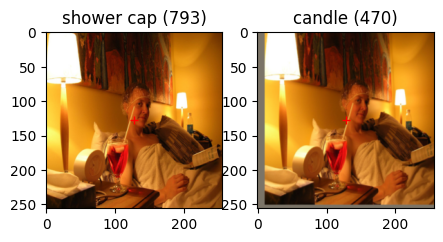

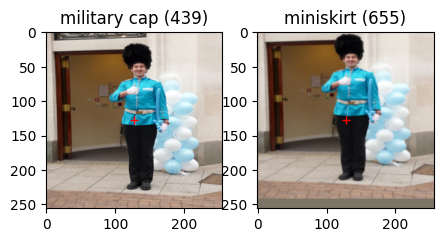

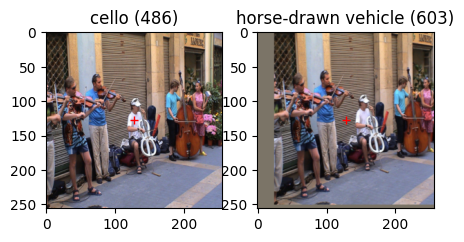

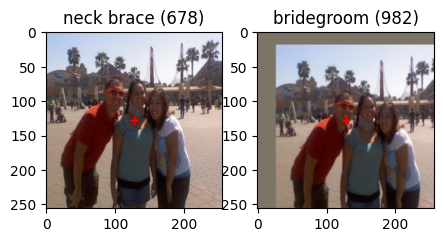

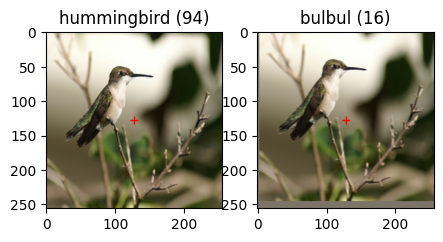

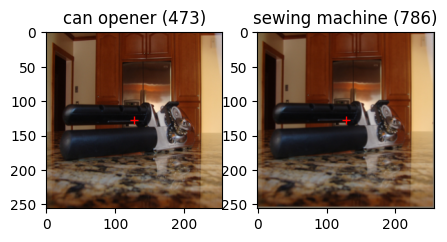

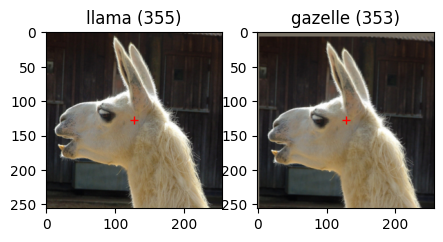

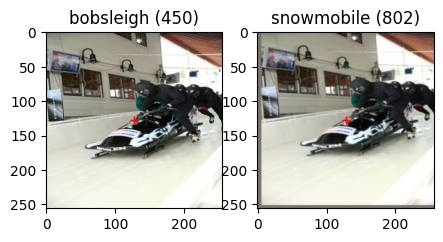

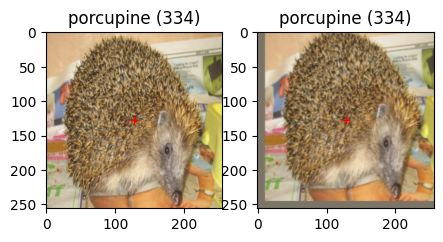

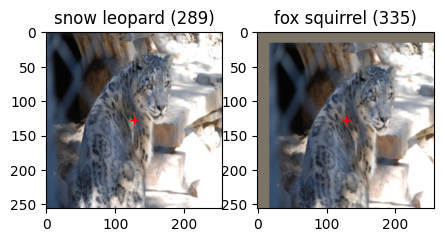

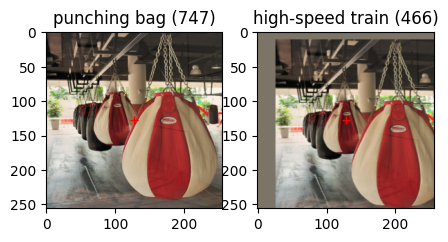

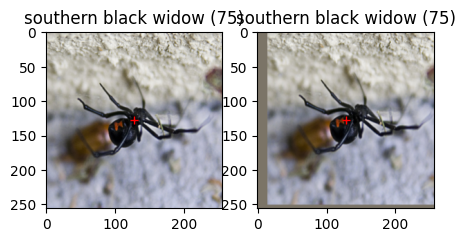

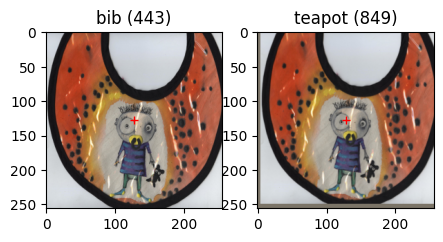

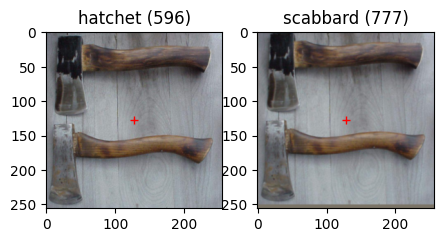

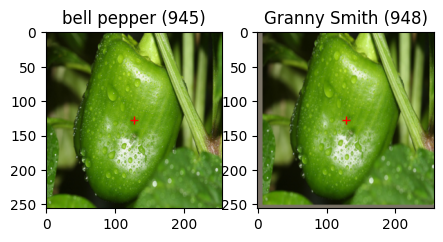

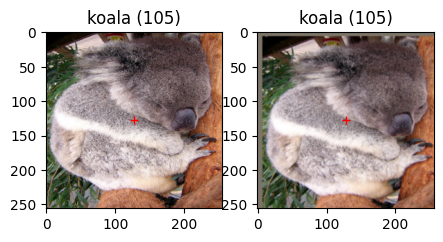

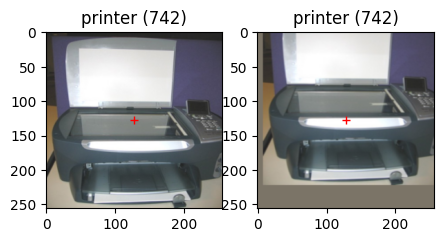

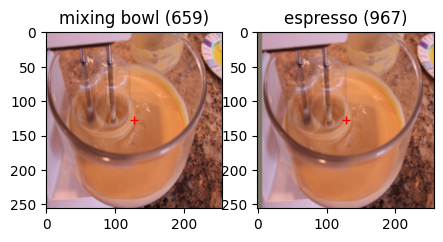

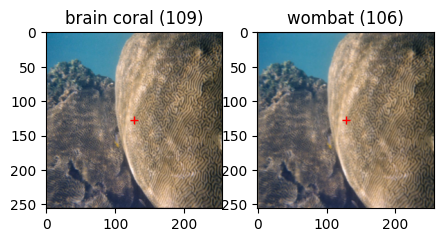

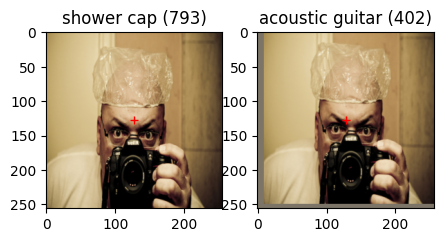

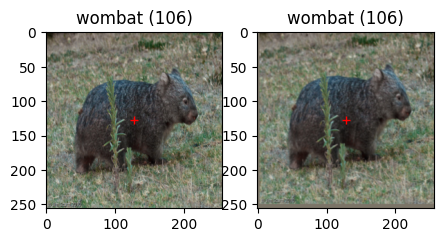

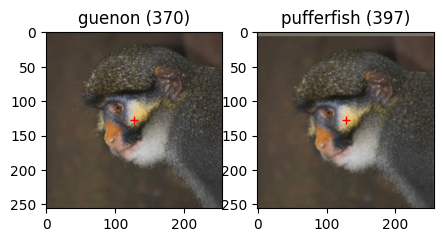

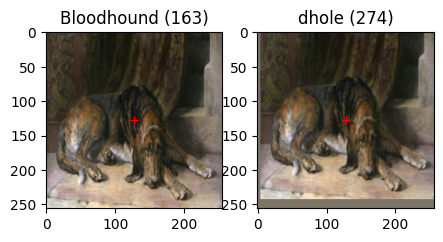

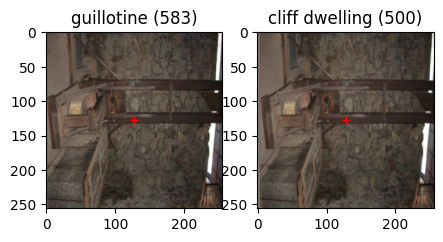

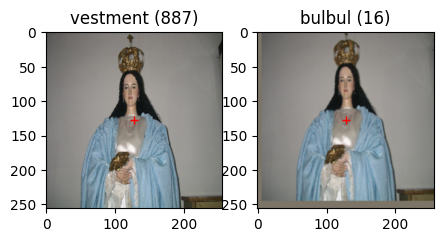

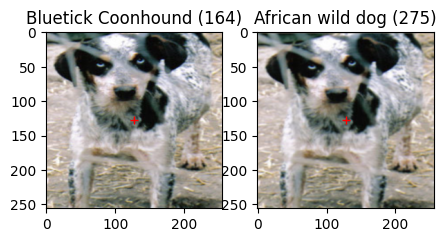

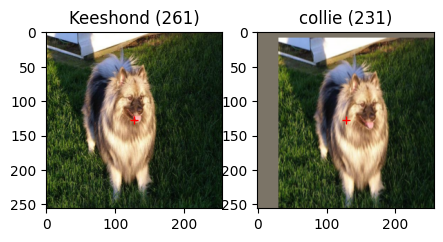

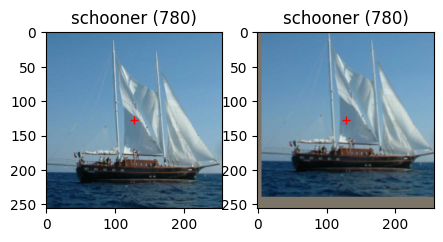

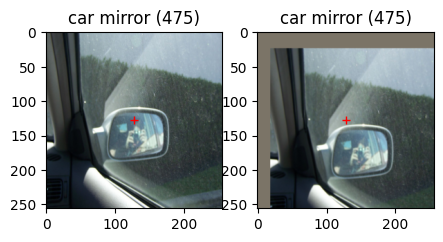

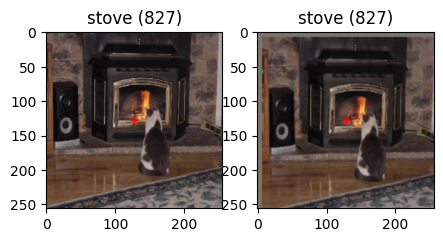

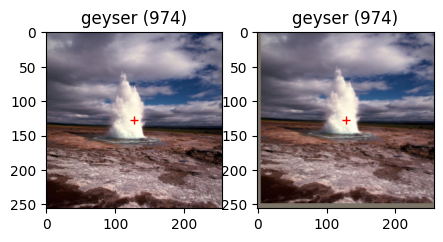

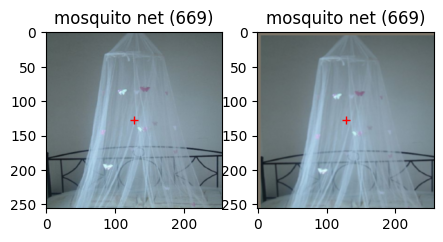

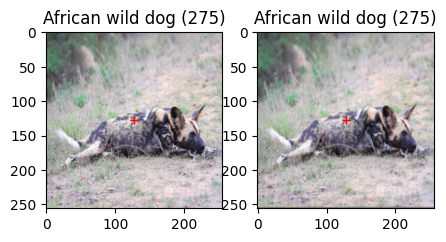

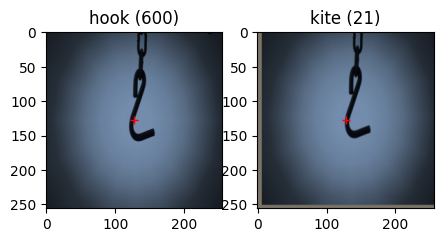

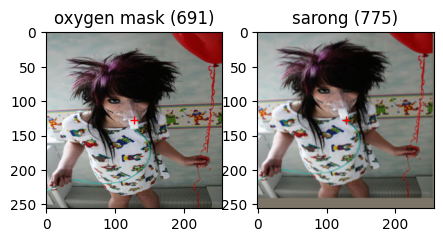

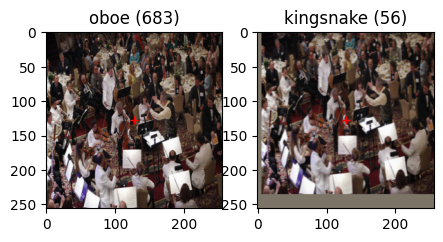

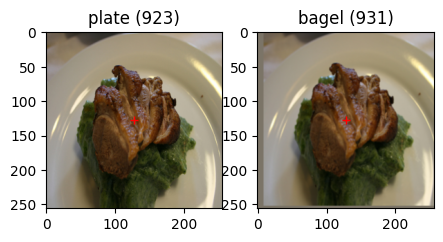

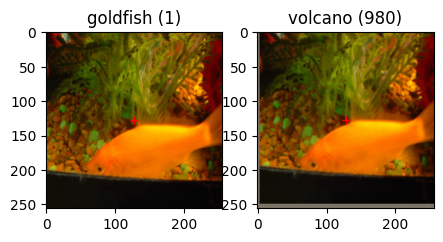

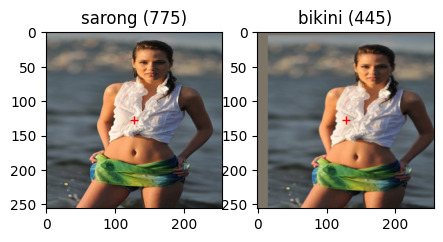

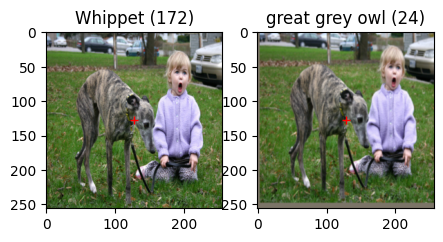

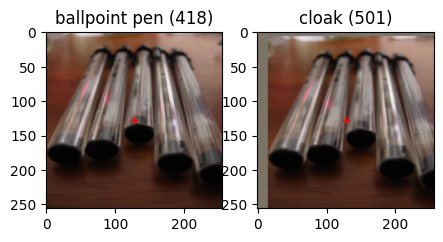

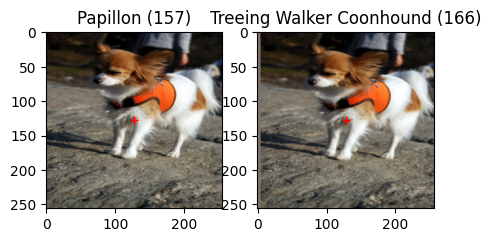

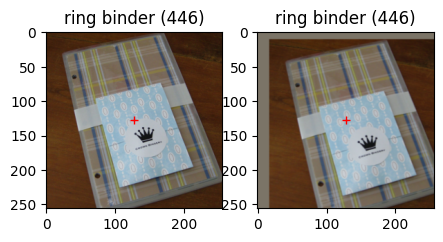

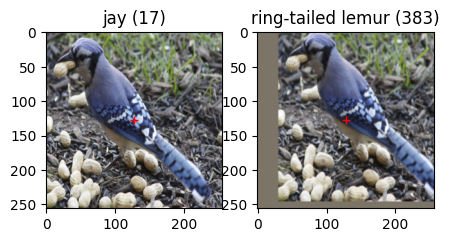

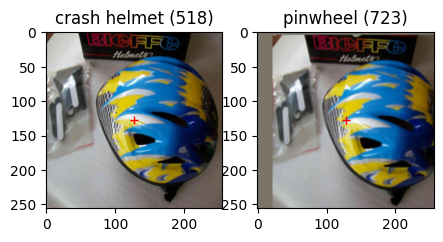

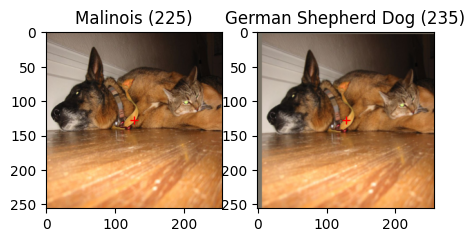

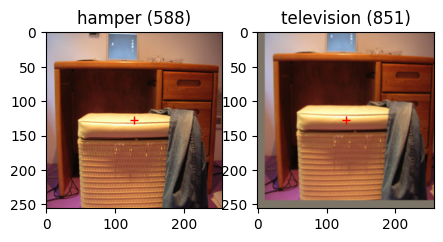

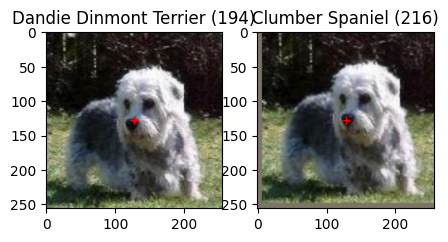

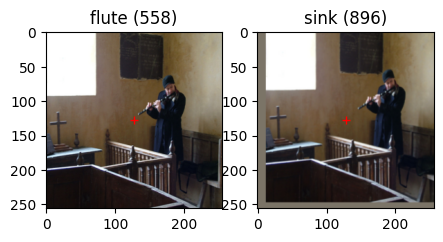

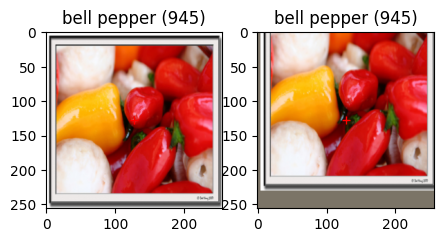

In [27]:
#theta = torch.cat((model.downscale.unsqueeze(0).repeat(
#            theta.size(0), 1, 1), theta.unsqueeze(2)),
#                          dim=2)
        
        #theta = theta.view(-1, 2, 3)
for num in range(50):
        plt.figure(figsize=(5,10))
        plt.subplot(1,2,1)
        img = data[0][num:num+1,...]   
        theta = output[1][num:num+1,...]
        #theta[0,:,2] = torch.FloatTensor((0,.5))
        print(theta[0,:,2].detach().numpy())
        grid_size = torch.Size([1, 3, 256, 256])
        grid = F.affine_grid(theta, grid_size)
        img_grid = F.grid_sample(img, grid.double())
        plt.imshow(img_denorm(data[0][num,...], v_mean, v_std).permute(1,2,0).detach().numpy())
        #plt.imshow(data[0][num,...].permute(1,2,0).detach().numpy())
        plt.plot(127.5, 127.5, 'r+')
        plt.title(class_labels[label[num]]+f' ({label[num]})')
        plt.subplot(1,2,2)
        plt.imshow(img_denorm(img_grid[0,:], v_mean, v_std).permute(1,2,0).detach().numpy())
        #plt.imshow(img_grid[0,:].permute(1,2,0).detach().numpy())
        plt.plot(127.5, 127.5, 'r+')
        plt.title(class_labels[cat[num]]+f' ({cat[num]})')

In [37]:
data[0][num:num+1,...]

tensor([[[[-1.0048, -0.9877, -0.9705,  ..., -1.0219, -1.0219, -1.0390],
          [-0.9534, -0.9534, -0.9534,  ..., -1.0048, -1.0219, -1.0219],
          [-0.9192, -0.9192, -0.9192,  ..., -1.0048, -1.0048, -1.0219],
          ...,
          [-1.2274, -1.2103, -1.0904,  ...,  0.6563,  0.6049,  0.6221],
          [-1.3987, -1.5014, -1.3644,  ...,  0.6563,  0.6392,  0.5878],
          [-1.4158, -1.5528, -1.4672,  ...,  0.7077,  0.6906,  0.5878]],

         [[-0.4251, -0.4076, -0.3901,  ..., -0.3725, -0.3725, -0.3901],
          [-0.3725, -0.3725, -0.3725,  ..., -0.3550, -0.3725, -0.3725],
          [-0.3375, -0.3375, -0.3375,  ..., -0.3550, -0.3550, -0.3725],
          ...,
          [-1.3004, -1.3004, -1.2129,  ...,  0.7129,  0.6779,  0.6779],
          [-1.3179, -1.5980, -1.5805,  ...,  0.6779,  0.6604,  0.6078],
          [-1.3004, -1.6331, -1.7206,  ...,  0.7304,  0.7129,  0.6078]],

         [[ 0.7576,  0.7751,  0.7925,  ...,  0.6705,  0.6705,  0.6531],
          [ 0.8099,  0.8099,  

In [42]:
data[0][num,...].shape

torch.Size([3, 256, 256])